<a href="https://colab.research.google.com/github/SebastianOrmaechea/Analisis-Supervisado-Grupo-32/blob/Garay_Carolina/Garay_Kaggle_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiploDatos Kaggle Competition

**Grupo 32**

Integrantes:

* Garay, Carolina del Valle
* Ormaechea, Sebastián Gabriel
* Ramos, Pablo Nicolás


En esta competencia, el objetivo es predecir si los pasajeros del conjunto de datos "test.csv" fueron transportados a una dimensión alternativa durante la colisión de la nave espacial Titanic con una anomalía del espacio-tiempo. Para ayudarlos a hacer estas predicciones, se les proporciona el conjunto de datos de los registros personales recuperados de la computadora dañada de la nave

train.csv Datos sobre gran parte de los pasajeros, a ser usados para entrenamiento.

-PassengerId - Un identificador para cada pasajero.

-HomePlanet - El planeta del cual partió el pasajero. Típicamente su planeta de residencia permanente.

-CryoSleep - Indica si el pasajero fue electo a ser puesto en suspensión animada durante la duración del viaje. Los pasajeros en CryoSleep están confinados a sus cabinas.

-Cabin - El número de cabina en donde el pasajero se está quedando. Toma la forma piso/número/lado, donde el lado puede ser P por Port oS por Starboard.

-Destination - El destino en donde va a desembarcar el pasajero.

-Age - La edad del pasajero.

-VIP - Si el pasajero pagó por servicios VIP durante el viaje.

-RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Cantidad que el pasajero ha gastado en cada una de las comodidades de lujo del Spaceship Titanic.

-Name - El nombre y apellido de cada pasajero.

**-Transported - Si el pasajero fue transportado a otra dimensión o no. Esta es la columna target, la columna a predecir.**

test.csv Records personales de los restantes pasajeros, a ser utilizados como datos nuevos desconocidos. Tu objetivo es predecir si cada pasajero de este conjunto fue transportado a otra dimensión o no (variable "Transported").

Deben subir el siguiente archivo: sample_submission.csv El archivo que deben entregar con las predicciones del conjunto test.csv . Debe tener dos columnas, una con el "PassengerId" y otra con el valor de la predicción en la columna "Transported" (0 si no fue transportado y 1 si fue transportado).

En el github de la materia hay un ejemplo de baseline para esta competencia.

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier

In [2]:
# Descarga de base de datos
!gdown https://drive.google.com/file/d/1Vclyh1LeOGSDe7Mxi-StHiGXgE5pdSkL/view?usp=sharing --fuzzy

!gdown https://drive.google.com/file/d/1YoAh1JANoRAKQr5zIFDeIAPY4fWbF1QW/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1Vclyh1LeOGSDe7Mxi-StHiGXgE5pdSkL
To: /content/train.csv
100% 681k/681k [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YoAh1JANoRAKQr5zIFDeIAPY4fWbF1QW
To: /content/test.csv
100% 74.2k/74.2k [00:00<00:00, 65.8MB/s]


In [3]:
df = pd.read_csv('/content/train.csv')

In [4]:
print(df.value_counts(df['HomePlanet'], sort = True))
df.isna().sum()

HomePlanet
Earth     4114
Europa    1935
Mars      1595
dtype: int64


PassengerId       0
HomePlanet      179
CryoSleep       196
Cabin           184
Destination     160
Age             162
VIP             184
RoomService     154
FoodCourt       155
ShoppingMall    188
Spa             158
VRDeck          169
Name            184
Transported       0
dtype: int64

In [5]:
df.loc[df['CryoSleep'] == False, 'CryoSleep'] = '0'
df.loc[df.CryoSleep == True, 'CryoSleep'] = '1'
df.loc[df['VIP'] == False, 'VIP'] = '0'
df.loc[df['VIP'] == True, 'VIP'] = '1'

df.loc[df['HomePlanet']=='Earth', 'HomePlanet'] = '0'
df.loc[df['HomePlanet']=='Europa', 'HomePlanet'] = '1'
df.loc[df['HomePlanet']=='Mars', 'HomePlanet'] = '2'

df.loc[df['Destination']=='TRAPPIST-1e', 'Destination']= '0'
df.loc[df['Destination']=='55 Cancri e', 'Destination']= '1'
df.loc[df['Destination']=='PSO J318.5-22', 'Destination']= '2'


In [6]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,1,0,C/123/P,0,57.0,0,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,2,1,F/126/S,NaN,18.0,0,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,1,1,B/343/S,0,33.0,NaN,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,0,0,F/1420/P,0,43.0,0,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,0,0,G/9/P,0,19.0,0,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,2,0,F/1319/S,0,12.0,NaN,0.0,0.0,0.0,0.0,0.0,Risps Hacle,1
7819,2693,0,0,G/459/S,0,44.0,0,0.0,0.0,744.0,62.0,3.0,Gabrie Reenez,0
7820,8076,2,1,F/1772/P,0,55.0,0,0.0,0.0,0.0,0.0,0.0,Panzel Ruity,1
7821,3829,0,0,E/253/P,0,15.0,0,0.0,840.0,123.0,0.0,20.0,Belly Weavesend,0


In [7]:
print(df.shape)
print(df.describe())

(7823, 14)
       PassengerId          Age   RoomService     FoodCourt  ShoppingMall  \
count  7823.000000  7661.000000   7669.000000   7668.000000   7635.000000   
mean   4345.691039    28.879389    226.078237    455.643062    172.600393   
std    2504.576803    14.461548    679.180148   1621.290107    597.923749   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%    2182.500000    19.000000      0.000000      0.000000      0.000000   
50%    4345.000000    27.000000      0.000000      0.000000      0.000000   
75%    6515.500000    38.000000     44.000000     69.000000     28.000000   
max    8692.000000    79.000000  14327.000000  29813.000000  23492.000000   

                Spa        VRDeck  Transported  
count   7665.000000   7654.000000  7823.000000  
mean     305.023222    295.476744     0.506711  
std     1133.423579   1093.485752     0.499987  
min        0.000000      0.000000     0.000000  
25%        0.000000      0.000000     0.000000  
5

In [8]:
print(df.value_counts(df['Transported'], sort = True))

Transported
1    3964
0    3859
dtype: int64


Observamos que no hay desbalance de datos

In [9]:
#Imprimimos tipo de dato de cada columna
df.dtypes

PassengerId       int64
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
dtype: object

In [10]:
#Imprimimos columnas que registran valores nulos
#True = contiene valor nulo
df.isna().sum()

PassengerId       0
HomePlanet      179
CryoSleep       196
Cabin           184
Destination     160
Age             162
VIP             184
RoomService     154
FoodCourt       155
ShoppingMall    188
Spa             158
VRDeck          169
Name            184
Transported       0
dtype: int64

In [11]:
df['Destination'].value_counts()                  


0    5316
1    1625
2     722
Name: Destination, dtype: int64

In [12]:
#Imprimimos nombre de cada columna
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

Imputamos datos faltantes

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
df[imputer_cols] = imputer.fit_transform(df[imputer_cols])
#y = df.Transported
#X = df.drop('Transported',axis=1)
#X

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [17]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,1,0,C/123/P,0,57.0,0,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,2,1,F/126/S,NaN,18.0,0,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,1,1,B/343/S,0,33.0,NaN,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,0,0,F/1420/P,0,43.0,0,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,0,0,G/9/P,0,19.0,0,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,2,0,F/1319/S,0,12.0,NaN,0.0,0.0,0.0,0.0,0.0,Risps Hacle,1
7819,2693,0,0,G/459/S,0,44.0,0,0.0,0.0,744.0,62.0,3.0,Gabrie Reenez,0
7820,8076,2,1,F/1772/P,0,55.0,0,0.0,0.0,0.0,0.0,0.0,Panzel Ruity,1
7821,3829,0,0,E/253/P,0,15.0,0,0.0,840.0,123.0,0.0,20.0,Belly Weavesend,0


Imputamos datos de variables categóricas

In [18]:
imputer_cols2 = ["HomePlanet", "CryoSleep","Destination", "VIP"]
imputer2 = SimpleImputer(strategy="median")
df[imputer_cols2] = imputer2.fit_transform(df[imputer_cols2])

In [19]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,1.0,0.0,C/123/P,0.0,57.0,0.0,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,2.0,1.0,F/126/S,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,1.0,1.0,B/343/S,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,0.0,0.0,F/1420/P,0.0,43.0,0.0,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,0.0,0.0,G/9/P,0.0,19.0,0.0,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,2.0,0.0,F/1319/S,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,Risps Hacle,1
7819,2693,0.0,0.0,G/459/S,0.0,44.0,0.0,0.0,0.0,744.0,62.0,3.0,Gabrie Reenez,0
7820,8076,2.0,1.0,F/1772/P,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,Panzel Ruity,1
7821,3829,0.0,0.0,E/253/P,0.0,15.0,0.0,0.0,840.0,123.0,0.0,20.0,Belly Weavesend,0


In [20]:
print(df.value_counts(df['HomePlanet'], sort = True))
print("      ")
print(df.value_counts(df['CryoSleep'], sort = True))
print("      ")
print(df.value_counts(df['Destination'], sort = True))
print(df.value_counts(df['Transported'], sort = True))

HomePlanet
0.0    4293
1.0    1935
2.0    1595
dtype: int64
      
CryoSleep
0.0    5067
1.0    2756
dtype: int64
      
Destination
0.0    5476
1.0    1625
2.0     722
dtype: int64
Transported
1    3964
0    3859
dtype: int64


In [21]:
df.isnull().any(axis=0)

PassengerId     False
HomePlanet      False
CryoSleep       False
Cabin            True
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Name             True
Transported     False
dtype: bool

No codificaremos las variables Cabin y Name dado que tienen mas de 1000 categorías

In [22]:
df2=df[['PassengerId','HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' ,'Transported']]

In [23]:
df2

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,3430,1.0,0.0,0.0,57.0,0.0,0.0,3859.0,13.0,195.0,3874.0,0
1,669,2.0,1.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,8430,1.0,1.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,6463,0.0,0.0,0.0,43.0,0.0,142.0,1208.0,0.0,0.0,204.0,0
4,85,0.0,0.0,0.0,19.0,0.0,0.0,0.0,670.0,1.0,34.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,2.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7819,2693,0.0,0.0,0.0,44.0,0.0,0.0,0.0,744.0,62.0,3.0,0
7820,8076,2.0,1.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7821,3829,0.0,0.0,0.0,15.0,0.0,0.0,840.0,123.0,0.0,20.0,0


In [24]:
y = df2.Transported
X = df2.drop('Transported', axis=1)

In [25]:
X

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,3430,1.0,0.0,0.0,57.0,0.0,0.0,3859.0,13.0,195.0,3874.0
1,669,2.0,1.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8430,1.0,1.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6463,0.0,0.0,0.0,43.0,0.0,142.0,1208.0,0.0,0.0,204.0
4,85,0.0,0.0,0.0,19.0,0.0,0.0,0.0,670.0,1.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...
7818,6528,2.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
7819,2693,0.0,0.0,0.0,44.0,0.0,0.0,0.0,744.0,62.0,3.0
7820,8076,2.0,1.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0
7821,3829,0.0,0.0,0.0,15.0,0.0,0.0,840.0,123.0,0.0,20.0


In [26]:
#Codificamos las variables categóricas y estandarizamos

passengerId = X.PassengerId
print(passengerId)
X.drop('PassengerId',axis=1,inplace=True)

print(X.columns)

x_names = X.columns
#X = StandardScaler().fit_transform(X) #Estandarizamos los datos
X = pd.DataFrame(X, columns=x_names)
X

0       3430
1        669
2       8430
3       6463
4         85
        ... 
7818    6528
7819    2693
7820    8076
7821    3829
7822    7624
Name: PassengerId, Length: 7823, dtype: int64
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,0.0,0.0,57.0,0.0,0.0,3859.0,13.0,195.0,3874.0
1,2.0,1.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,43.0,0.0,142.0,1208.0,0.0,0.0,204.0
4,0.0,0.0,0.0,19.0,0.0,0.0,0.0,670.0,1.0,34.0
...,...,...,...,...,...,...,...,...,...,...
7818,2.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
7819,0.0,0.0,0.0,44.0,0.0,0.0,0.0,744.0,62.0,3.0
7820,2.0,1.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0
7821,0.0,0.0,0.0,15.0,0.0,0.0,840.0,123.0,0.0,20.0


In [27]:
#Imprimimos columnas que registran valores nulos
#True = contiene valor nulo
X.isnull().any(axis=0)

HomePlanet      False
CryoSleep       False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
dtype: bool

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

Escalamos los conjuntos

In [29]:
scaler = StandardScaler()
scaler.fit(x_train)  # Conjunto de entrenamiento
X_strain = scaler.transform(x_train)
X_stest = scaler.transform(x_test)  # Conjunto de evaluación

### Planteo modelos
Tienen que elegir los 2 mejores modelos así que prueben con varios.

In [30]:
clfs = [DecisionTreeClassifier()]
names = ['Árbol de decisión']

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train, y_train)
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    train_predictions2 = clf.predict(x_test)
    accuracy = accuracy_score(y_test, train_predictions2)
    print("Accuracy test {names}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)

Árbol de decisión
Accuracy train Árbol de decisión: 93.21%
Accuracy test {names}: 73.10%


### Algún tipo de ajuste de hiperparámetros de los modelos elegidos

In [31]:
grid = GridSearchCV(DecisionTreeClassifier(),
 {'criterion':('gini','entropy'),
 'splitter':("best","random"),
 'max_depth':(10,20,100)})
grid.fit(x_train,y_train)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}

Accuracy train Arbol de decisión: 82.66%
Accuracy test Arbol de decisión: 79.62%


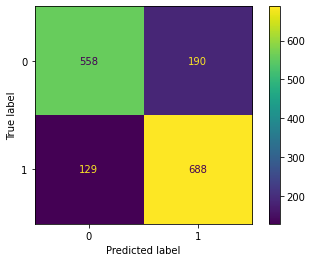

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       748
           1       0.78      0.84      0.81       817

    accuracy                           0.80      1565
   macro avg       0.80      0.79      0.79      1565
weighted avg       0.80      0.80      0.80      1565



In [32]:
clf = DecisionTreeClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions3 = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions3)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions3 = clf.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions3)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions3)
plt.show()

print(classification_report(y_test,clf.predict(x_test)))

In [33]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train)
y_train2 = np.array(y_train)


for clfi, name in zip([DecisionTreeClassifier(**grid.best_params_)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

DecisionTreeClassifier(criterion='entropy', max_depth=10)
Precisión test fold 0: 76.28
Precisión test fold 1: 79.15
Precisión test fold 2: 77.32
Precisión test fold 3: 79.14
Precisión test fold 4: 76.98
Avg. accuracy = 77.77254234950698


In [34]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_verd, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_verd, y_pred)
    classes = classes[unique_labels(y_verd, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    if ax == None:
        fig, ax = plt.subplots()    


    am = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(am, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='Etiqueta correcta',
           xlabel='Etiqueta predicha',
           title=title,)

    

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    return ax

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

******************************************************************
*********Hiperparámetros para citerio de partición gini *********
Mejor conjunto de parámetros:
{'max_depth': 10, 'min_samples_leaf': 1}
Train dataset accuracy: 0.832
****Reporte de clasificación sobre conjunto de entrenamiento (métricas)*****
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3111
           1       0.80      0.89      0.84      3147

    accuracy                           0.83      6258
   macro avg       0.84      0.83      0.83      6258
weighted avg       0.84      0.83      0.83      6258

Test dataset accuracy: 0.784
****Reporte de clasificación sobre conjunto de evaluación*****
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       748
           1       0.77      0.83      0.80       817

    accuracy                           0.78      1565
   macro avg       0.79      0.78      0.78      156

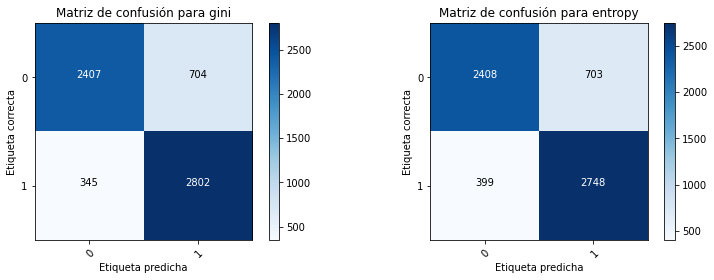

In [36]:
fig, ax2 = plt.subplots(1,2,figsize=(13, 4))
for n, criterion in enumerate(('gini','entropy')):
    param_grid2 = {
     'max_depth': [10,20,100],  # Profundidad máxima del árbol
        'min_samples_leaf': [1,2],  # Cantidad mínima de samples por hoja
    }
    modelt = tree.DecisionTreeClassifier(random_state=22,criterion=criterion)
    cvt = GridSearchCV(modelt, param_grid2, scoring='accuracy',cv=5)
    cvt.fit(x_train, y_train)

    print("******************************************************************")
    print("*********Hiperparámetros para citerio de partición",criterion,"*********")
    print("Mejor conjunto de parámetros:")
    print(cvt.best_params_)
    print("Train dataset accuracy: %0.03f" % cvt.score(x_train,y_train))

    y_train_predtt = cvt.predict(x_train)
    y_test_predt = cvt.predict(x_test)
    print("****Reporte de clasificación sobre conjunto de entrenamiento (métricas)*****") 
    print(classification_report(y_train, y_train_predtt))
    
    #ConfusionMatrixDisplay.from_predictions(y_train, y_train_predtt)
    #plt.show() 

    print("Test dataset accuracy: %0.03f" % cvt.score(x_test,y_test))
    print("****Reporte de clasificación sobre conjunto de evaluación*****") 
    print(classification_report(y_test, y_test_predt))
    #ConfusionMatrixDisplay.from_predictions(y_test, y_test_predt)
    #plt.show() 

    plot_confusion_matrix(y_train, y_train_predtt, classes=df.Transported.unique(),
                      ax=ax2[n],title="Matriz de confusión para %s" % criterion)
    

In [37]:
from sklearn.ensemble import RandomForestClassifier as RFC

params={#'criterion':('gini','entropy'), 
        'min_samples_leaf':(2,3,4),
        'min_samples_split':(100,110,120),
        #'max_features':("auto","sqrt","log2",None),
        'n_estimators' : (70,80,90)}

clf2 = RFC(random_state=22,criterion='gini',max_features=None)
grid = GridSearchCV(clf2, params, scoring='accuracy', cv=5,n_jobs=4)
grid.fit(x_train,y_train)
print('Best Decision Tree accuracy: ',grid.best_score_)
print(grid.best_estimator_)

'params={#\'criterion\':(\'gini\',\'entropy\'), \n        \'min_samples_leaf\':(2,3,4),\n        \'min_samples_split\':(100,110,120),\n        #\'max_features\':("auto","sqrt","log2",None),\n        \'n_estimators\' : (70,80,90)}\n\nclf2 = RFC(random_state=22,criterion=\'gini\',max_features=None)\ngrid = GridSearchCV(clf2, params, scoring=\'accuracy\', cv=5,n_jobs=4)\ngrid.fit(x_train,y_train)\nprint(\'Best Decision Tree accuracy: \',grid.best_score_)\nprint(grid.best_estimator_)'

In [38]:
params={#'criterion':('gini','entropy'), 
        'min_samples_leaf':(2,3,4),
        'min_samples_split':(100,110,120),
        #'max_features':("auto","sqrt","log2",None),
        'n_estimators' : (70,80,90)}

clf5 = RFC(random_state=22,criterion='entropy',max_features=None)
grid = GridSearchCV(clf5, params, scoring='accuracy', cv=5,n_jobs=4)
grid.fit(x_train,y_train)
print('Best Decision Tree accuracy: ',grid.best_score_)
print(grid.best_estimator_)

'params={#\'criterion\':(\'gini\',\'entropy\'), \n        \'min_samples_leaf\':(2,3,4),\n        \'min_samples_split\':(100,110,120),\n        #\'max_features\':("auto","sqrt","log2",None),\n        \'n_estimators\' : (70,80,90)}\n\nclf5 = RFC(random_state=22,criterion=\'entropy\',max_features=None)\ngrid = GridSearchCV(clf5, params, scoring=\'accuracy\', cv=5,n_jobs=4)\ngrid.fit(x_train,y_train)\nprint(\'Best Decision Tree accuracy: \',grid.best_score_)\nprint(grid.best_estimator_)'

In [39]:
clf5 = RFC(random_state=22, criterion="entropy",
                                       max_features=None, min_samples_leaf=3,
                       min_samples_split=110, n_estimators=90)
clf5.fit(x_train, y_train)
print("Train dataset accuracy: %0.03f" % clf5.score(x_train,y_train))

Train dataset accuracy: 0.809


Test dataset accuracy: 0.802
****Reporte de clasificación sobre conjunto de evaluación (métricas)*****
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       748
           1       0.80      0.82      0.81       817

    accuracy                           0.80      1565
   macro avg       0.80      0.80      0.80      1565
weighted avg       0.80      0.80      0.80      1565



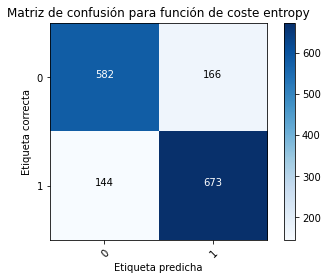

In [40]:
y_test_predt5 = clf5.predict(x_test)
print("Test dataset accuracy: %0.03f" % clf5.score(x_test,y_test))
print("****Reporte de clasificación sobre conjunto de evaluación (métricas)*****") 
print(classification_report(y_test, y_test_predt5)) 
plot_confusion_matrix(y_test, y_test_predt5, classes=df.Transported.unique(),
                        title="Matriz de confusión para función de coste entropy");

In [41]:

clf3 = RFC(random_state=22, criterion="gini",
                                       max_features=None, min_samples_leaf=4,
                       min_samples_split=100, n_estimators=90)
clf3.fit(x_train, y_train)
print("Train dataset accuracy: %0.03f" % clf3.score(x_train,y_train))

Train dataset accuracy: 0.809


Test dataset accuracy: 0.802
****Reporte de clasificación sobre conjunto de evaluación (métricas)*****
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       748
           1       0.80      0.82      0.81       817

    accuracy                           0.80      1565
   macro avg       0.80      0.80      0.80      1565
weighted avg       0.80      0.80      0.80      1565



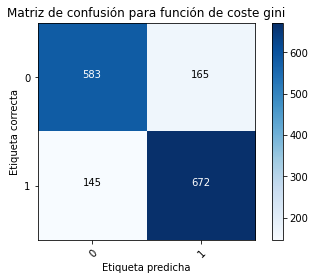

In [42]:
y_test_predtt = clf3.predict(x_test)
print("Test dataset accuracy: %0.03f" % clf3.score(x_test,y_test))
print("****Reporte de clasificación sobre conjunto de evaluación (métricas)*****") 
print(classification_report(y_test, y_test_predtt)) 
plot_confusion_matrix(y_test, y_test_predtt, classes=df.Transported.unique(),
                        title="Matriz de confusión para función de coste gini");

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [45]:
params = {'n_neighbors':(3,5,7,10,15,20),
          #'algorithm':('auto','ball_tree','kd_tree'),
          'leaf_size':(5,10,20,30)
         }

clf4 = KNeighborsClassifier(algorithm='kd_tree')
grid4 = GridSearchCV(clf4, params, scoring='accuracy', cv=5, n_jobs=4)
grid4.fit(x_train,y_train)
print('Best Decision Tree accuracy: ', grid4.best_score_)
print('Best Decision Tree accuracy: ', grid4.score(x_train,y_train))
print(grid4.best_params_)
print(grid4.best_estimator_)


Best Decision Tree accuracy:  0.7850760924806481
Best Decision Tree accuracy:  0.8058485139022051
{'leaf_size': 5, 'n_neighbors': 15}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=5, n_neighbors=15)


In [46]:
clf4 = KNeighborsClassifier(algorithm='kd_tree', leaf_size=5, n_neighbors=15)
clf4.fit(x_train, y_train)
print("Train dataset accuracy: %0.03f" % clf3.score(x_train,y_train))

Train dataset accuracy: 0.809


Test dataset accuracy: 0.783
****Reporte de clasificación sobre conjunto de evaluación (métricas)*****
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       748
           1       0.78      0.81      0.80       817

    accuracy                           0.78      1565
   macro avg       0.78      0.78      0.78      1565
weighted avg       0.78      0.78      0.78      1565



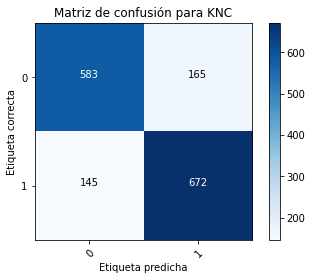

In [47]:
y_test_predk = clf4.predict(x_test)
print("Test dataset accuracy: %0.03f" % clf4.score(x_test,y_test))
print("****Reporte de clasificación sobre conjunto de evaluación (métricas)*****") 
print(classification_report(y_test, y_test_predk)) 
plot_confusion_matrix(y_test, y_test_predtt, classes=df.Transported.unique(),
                        title="Matriz de confusión para KNC");

## Generar la salida para entregar

In [105]:
test_df = pd.read_csv('test.csv')

In [106]:
test_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [107]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,Europa,True,NaN,55 Cancri e,34.0,False,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,Earth,True,G/1489/S,PSO J318.5-22,13.0,False,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,Earth,False,G/776/P,TRAPPIST-1e,44.0,False,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,Earth,False,E/577/S,PSO J318.5-22,63.0,False,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,Europa,False,B/117/S,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,5996,Mars,False,F/1212/S,TRAPPIST-1e,54.0,False,676.0,0.0,231.0,379.0,0.0,Anch Perta
866,5478,Earth,True,G/947/S,TRAPPIST-1e,58.0,False,0.0,0.0,0.0,0.0,0.0,Hughy Hessey
867,6760,Earth,True,G/1148/P,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Heidie Kimpson
868,1437,Earth,False,F/293/S,TRAPPIST-1e,18.0,False,765.0,0.0,13.0,0.0,0.0,Herina Oconley


Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [108]:
test_df.loc[test_df['CryoSleep'] == False, 'CryoSleep'] = '0'
test_df.loc[test_df.CryoSleep == True, 'CryoSleep'] = '1'
test_df.loc[test_df['VIP'] == False, 'VIP'] = '0'
test_df.loc[test_df['VIP'] == True, 'VIP'] = '1'

test_df.loc[test_df['HomePlanet']=='Earth', 'HomePlanet'] = '0'
test_df.loc[test_df['HomePlanet']=='Europa', 'HomePlanet'] = '1'
test_df.loc[test_df['HomePlanet']=='Mars', 'HomePlanet'] = '2'

test_df.loc[test_df['Destination']=='TRAPPIST-1e', 'Destination']= '0'
test_df.loc[test_df['Destination']=='55 Cancri e', 'Destination']= '1'
test_df.loc[test_df['Destination']=='PSO J318.5-22', 'Destination']= '2'


In [109]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,1,1,NaN,1,34.0,0,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,0,1,G/1489/S,2,13.0,0,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,0,0,G/776/P,0,44.0,0,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,0,0,E/577/S,2,63.0,0,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,1,0,B/117/S,1,10.0,0,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,5996,2,0,F/1212/S,0,54.0,0,676.0,0.0,231.0,379.0,0.0,Anch Perta
866,5478,0,1,G/947/S,0,58.0,0,0.0,0.0,0.0,0.0,0.0,Hughy Hessey
867,6760,0,1,G/1148/P,2,18.0,0,0.0,0.0,0.0,0.0,0.0,Heidie Kimpson
868,1437,0,0,F/293/S,0,18.0,0,765.0,0.0,13.0,0.0,0.0,Herina Oconley


In [110]:
imputer_colst = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputert = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
test_df[imputer_colst] = imputert.fit_transform(test_df[imputer_colst])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [111]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,1,1,NaN,1,34.0,0,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,0,1,G/1489/S,2,13.0,0,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,0,0,G/776/P,0,44.0,0,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,0,0,E/577/S,2,63.0,0,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,1,0,B/117/S,1,10.0,0,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,5996,2,0,F/1212/S,0,54.0,0,676.0,0.0,231.0,379.0,0.0,Anch Perta
866,5478,0,1,G/947/S,0,58.0,0,0.0,0.0,0.0,0.0,0.0,Hughy Hessey
867,6760,0,1,G/1148/P,2,18.0,0,0.0,0.0,0.0,0.0,0.0,Heidie Kimpson
868,1437,0,0,F/293/S,0,18.0,0,765.0,0.0,13.0,0.0,0.0,Herina Oconley


In [112]:
imputer_cols2t = ["HomePlanet", "CryoSleep","Destination", "VIP"]
imputer2t = SimpleImputer(strategy="median")
test_df[imputer_cols2] = imputer2t.fit_transform(test_df[imputer_cols2t])

In [113]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,1.0,1.0,NaN,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,0.0,1.0,G/1489/S,2.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,0.0,0.0,G/776/P,0.0,44.0,0.0,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,0.0,0.0,E/577/S,2.0,63.0,0.0,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,1.0,0.0,B/117/S,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,5996,2.0,0.0,F/1212/S,0.0,54.0,0.0,676.0,0.0,231.0,379.0,0.0,Anch Perta
866,5478,0.0,1.0,G/947/S,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,Hughy Hessey
867,6760,0.0,1.0,G/1148/P,2.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Heidie Kimpson
868,1437,0.0,0.0,F/293/S,0.0,18.0,0.0,765.0,0.0,13.0,0.0,0.0,Herina Oconley


In [114]:
PassengerId = test_df.PassengerId

In [115]:
df2t=test_df[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

In [116]:
df2t

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,1.0,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,2.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,44.0,0.0,22.0,1.0,0.0,864.0,0.0
3,0.0,0.0,2.0,63.0,0.0,0.0,0.0,80.0,0.0,2322.0
4,1.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
865,2.0,0.0,0.0,54.0,0.0,676.0,0.0,231.0,379.0,0.0
866,0.0,1.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0
867,0.0,1.0,2.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
868,0.0,0.0,0.0,18.0,0.0,765.0,0.0,13.0,0.0,0.0


In [104]:
#no estandarizamos

"""
print(PassengerId)
df2t.drop(['PassengerId'], inplace=True, axis=1)
print(df2t.columns)

cols = df2t.columns
#df2t = StandardScaler().fit_transform(df2t) #Estandarizamos los datos
df2t = pd.DataFrame(df2t, columns=cols)
df2t"""

"\nprint(PassengerId)\ndf2t.drop(['PassengerId'], inplace=True, axis=1)\nprint(df2t.columns)\n\ncols = df2t.columns\n#df2t = StandardScaler().fit_transform(df2t) #Estandarizamos los datos\ndf2t = pd.DataFrame(df2t, columns=cols)\ndf2t"

In [117]:
df2t

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,1.0,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,2.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,44.0,0.0,22.0,1.0,0.0,864.0,0.0
3,0.0,0.0,2.0,63.0,0.0,0.0,0.0,80.0,0.0,2322.0
4,1.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
865,2.0,0.0,0.0,54.0,0.0,676.0,0.0,231.0,379.0,0.0
866,0.0,1.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0
867,0.0,1.0,2.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
868,0.0,0.0,0.0,18.0,0.0,765.0,0.0,13.0,0.0,0.0


Generamos la salida

In [118]:
test_id = PassengerId
test_pred = clf5.predict(df2t)


In [119]:
test_pred

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,

In [120]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("sample_submission.csv", header=True, index=False)

In [121]:
test_id

0       415
1      8663
2      4524
3      8246
4      2935
       ... 
865    5996
866    5478
867    6760
868    1437
869    5171
Name: PassengerId, Length: 870, dtype: int64

In [122]:
submission

,PassengerId,Transported
0,415,1
1,8663,1
2,4524,0
3,8246,0
4,2935,1
...,...,...
865,5996,0
866,5478,1
867,6760,1
868,1437,0


In [123]:
print(submission.value_counts(submission['Transported'], sort = True))

Transported
1    442
0    428
dtype: int64


In [75]:
!gdown https://drive.google.com/file/d/12XF6efjsdiI32NHs1ctsY7g5QXP8cQX4/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=12XF6efjsdiI32NHs1ctsY7g5QXP8cQX4
To: /content/sample_submission.csv
100% 6.00k/6.00k [00:00<00:00, 6.59MB/s]


In [76]:
df2 = pd.read_csv('sample_submission.csv')

In [77]:
df2

,PassengerId,Transported
0,415,1
1,8663,1
2,4524,0
3,8246,0
4,2935,0
...,...,...
865,5996,0
866,5478,1
867,6760,1
868,1437,0


In [78]:
print(df2.value_counts(df2['Transported'], sort = True))

Transported
0    460
1    410
dtype: int64


In [79]:
#DESCRAGA DE DATOS
from google.colab import files
#files.download('df_filtro_Ment_G1.csv')
#files.download('df_sin_filtro_Ment_G1.csv')